In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("./data/variables/")
figures_path = Path("./viz/")
embeddings_data_path = Path("data/embeddings/")

In [5]:
# plt.style.use("matplotlib_style.txt")

Pipeline from PubMedBERT embeddings to two dimensional embedding

# Import data

In [12]:
%%time
%%memit
embeddings_reparsed_all = np.load(
    embeddings_data_path
    / "embeddings_microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_44508.npy"
)

peak memory: 498.14 MiB, increment: 260.97 MiB
CPU times: user 48 ms, sys: 44 ms, total: 92.1 ms
Wall time: 592 ms


In [14]:
embeddings_reparsed_all.shape

(44508, 768)

In [16]:
%%capture cap

UsageError: %%capture is a cell magic, but the cell body is empty.


%%capture cap

# t-SNE

Annealing exgg=1, n_iter=2000 

## Affinities
- see https://opentsne.readthedocs.io/en/latest/api/affinity.html#openTSNE.affinity.Uniform
- Returns an NxM affinity matrix expressing interactions between N new data points the initial NxM data samples.
- Uniform: Compute affinities using nearest neighbors and uniform kernel in the ambient space.


In [21]:
A = affinity.Uniform(
    embeddings_reparsed_all,
    k_neighbors=10,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 7.20 seconds


/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


In [25]:
# save results
sp.sparse.save_npz(variables_path / "affinities_P_bert_reparsed", A.P)

In [27]:
# load affinities P
affinities_P_bert_reparsed = sp.sparse.load_npz(
    variables_path / "affinities_P_bert_reparsed.npz"
)

In [29]:
# create the affinities object

A = Affinities()
A.P = affinities_P_bert_reparsed

In [31]:
A.P

<44508x44508 sparse matrix of type '<class 'numpy.float64'>'
	with 758551 stored elements in Compressed Sparse Row format>

In [33]:
A.P.shape

(44508, 44508)

## Initialization

In [36]:
%%time
%%memit

I = initialization.pca(embeddings_reparsed_all, random_state=42)

np.save(variables_path / "initialization_bert_reparsed", I)

peak memory: 980.89 MiB, increment: 528.55 MiB
CPU times: user 4.58 s, sys: 706 ms, total: 5.29 s
Wall time: 1.14 s


In [37]:
I = np.load(variables_path / "initialization_bert_reparsed.npy")

In [40]:
I.shape

(44508, 2)

## Optimization

In [43]:
Zs = []
kls = []
n_iter = []


def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

- Early Exaggeration: This phase amplifies the differences between data points in the high-dimensional space, making clusters in the data more distinct. It helps the optimization process to escape local minima and find a better global organization of the data.
n_iter=125: The number of iterations to run during this phase.
exaggeration=12: The exaggeration factor increases the effective distance between points, emphasizing the separation of clusters.
- Exaggeration Annealing: Gradually reduces the exaggeration factor from 12 to 1 over 125 iterations. This process smoothly transitions the emphasis from global structure (early exaggeration) to local detail, refining the embedding.
np.linspace(12, 1, 125): Generates a sequence of exaggeration values decreasing from 12 to 1.

%%capture cap
%%time

In [47]:
E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(
    n_iter=125,
    exaggeration=12,
    momentum=0.5,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

# exaggeration annealing
exs = np.linspace(12, 1, 125)
for i in range(125):
    if (i + 1) % 50 == 0:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
            callbacks=mycallback,
            callbacks_every_iters=1,
        )

    else:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
        )

# final optimization without exaggeration
E = E.optimize(
    n_iter=2000,
    exaggeration=1,
    momentum=0.8,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

===> Running optimization with exaggeration=12.00, lr=3709.00 for 125 iterations...
Iteration   50, KL divergence 7.6284, 50 iterations in 0.6330 sec
Iteration  100, KL divergence 7.4135, 50 iterations in 0.6294 sec
   --> Time elapsed: 1.58 seconds
===> Running optimization with exaggeration=12.00, lr=3709.00 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.91, lr=3736.62 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.82, lr=3764.66 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.73, lr=3793.12 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.65, lr=3822.02 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.56, lr=3851.36 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.47, lr=

In [48]:
Zs_array = []
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [51]:
# save results
f = open(variables_path / "Zs_array_reparsed.pkl", "wb")
pickle.dump(Zs_array, f)
f.close()

In [53]:
# #load
# pickle_in = open( variables_path / "Zs_array_reparsed.pkl","rb")
# Zs_array = pickle.load(pickle_in)

In [55]:
# save iter
f = open(variables_path / "iterations_reparsed.pkl", "wb")
pickle.dump(n_iter, f)
f.close()

In [57]:
# #load
# pickle_in = open( variables_path / "iterations_reparsed.pkl","rb")
# iterations = pickle.load(pickle_in)

In [59]:
# save kl divergence
f = open(variables_path / "kl_divergence_reparsed.pkl", "wb")
pickle.dump(kls, f)
f.close()

In [61]:
# #load
# pickle_in = open( variables_path / "kl_divergence_reparsed.pkl","rb")
# kls = pickle.load(pickle_in)

In [63]:
tsne = np.array(E)

# save
np.save(variables_path / "tsne_reparsed", tsne)

In [ ]:
# tsne_reparsed=np.load( variables_path / "tsne_reparsed.npy")

# Save for Dashboard

In [6]:
tsne = np.load(variables_path / "tsne_reparsed.npy")

In [7]:
tsne.shape

(44508, 2)

In [8]:
df_tsne = pd.DataFrame(tsne, columns=["x_tsne", "y_tsne"])
df_tsne.head()

,x_tsne,y_tsne
0,28.514980,-65.738569
1,132.628590,25.220328
2,-115.404690,9.416150
3,-7.721526,-68.590372
4,79.324284,-96.366498


In [9]:
df_metadata = pd.read_csv("data/input/ddg2p_db.csv")
df_metadata = df_metadata.drop_duplicates(subset="pmid", keep="first")[
    ["pmid", "gene"]
]
df_metadata["pmid_gene"] = (
    "PMID:"
    + df_metadata["pmid"].astype(int).astype(str)
    + "|GENE:"
    + df_metadata["gene"]
)
df_metadata.shape

(44508, 3)

In [10]:
df_metadata = df_metadata.reset_index(drop=True)
df_tsne = df_tsne.reset_index(drop=True)

df_combined_for_dashboard = pd.concat([df_metadata, df_tsne], axis=1)
df_combined_for_dashboard.head()

,pmid,gene,pmid_gene,x_tsne,y_tsne
0,7866404,COL2A1,PMID:7866404|GENE:COL2A1,28.514980,-65.738569
1,7866411,PAH,PMID:7866411|GENE:PAH,132.628590,25.220328
2,7868125,ATN1,PMID:7868125|GENE:ATN1,-115.404690,9.416150
3,7870075,FBN1,PMID:7870075|GENE:FBN1,-7.721526,-68.590372
4,7874109,RET,PMID:7874109|GENE:RET,79.324284,-96.366498


In [11]:
df_combined_for_dashboard.shape

(44508, 5)

In [12]:
df_with_pos_go = pd.read_csv("data/output/df_for_dashboard.csv")
df_with_pos_all = pd.merge(
    df_with_pos_go,
    df_combined_for_dashboard[["pmid_gene", "x_tsne", "y_tsne"]],
    on="pmid_gene",
    how="left",
)
df_with_pos_all.shape

(47809, 15)

In [13]:
df_with_pos_all.head()

,pmid,title,pmid_gene,pmid_title_gene_path,pmid_title_gene_go_process,gene,disease,highest_level_path,GO_biological_process_first,pubdate,journal,x_go_process,y_go_process,x_tsne,y_tsne
0,7866404,Autosomal dominant spondylarthropathy due to a...,PMID:7866404|GENE:COL2A1,7866404: Autosomal dominant spondylarthropathy...,7866404: Autosomal dominant spondylarthropathy...,COL2A1,Kniest Dysplasia,Developmental Biology,Skeletal System Development,1994,Human mutation,-0.698466,-1.366203,28.514980,-65.738569
1,7866411,Phenylketonuria in southern Poland: a new spli...,PMID:7866411|GENE:PAH,7866411: Phenylketonuria in southern Poland: a...,7866411: Phenylketonuria in southern Poland: a...,PAH,Non-Phenylketonuria Hyperphenylalaninemia,Diseases of Metabolism,Catecholamine Biosynthetic Process,1994,Human mutation,6.335828,-5.524163,132.628590,25.220328
2,7868125,Elongated CAG repeats of the B37 gene in a Dan...,PMID:7868125|GENE:ATN1,7868125: Elongated CAG repeats of the B37 gene...,7868125: Elongated CAG repeats of the B37 gene...,ATN1,"Congenital Hypotonia, Epilepsy, Developmental ...",Signal Transduction,Central Nervous System Development,1995,Human genetics,0.874702,-7.217078,-115.404690,9.416150
3,7870075,A novel mutation in the fibrillin gene (FBN1) ...,PMID:7870075|GENE:FBN1,7870075: A novel mutation in the fibrillin gen...,7870075: A novel mutation in the fibrillin gen...,FBN1,Marfan Syndrome,Metabolism of Proteins,Eye Development,1994,Molecular and cellular probes,3.273770,-3.147037,-7.721526,-68.590372
4,7874109,RET proto-oncogene mutations in French MEN 2A ...,PMID:7874109|GENE:RET,7874109: RET proto-oncogene mutations in Frenc...,7874109: RET proto-oncogene mutations in Frenc...,RET,Multiple Endocrine Neoplasia Iib,Developmental Biology,Positive Regulation of RNA Biosynthetic Process,1994,Human molecular genetics,-1.766012,5.799867,79.324284,-96.366498


In [14]:
duplicated_rows = df_with_pos_all[
    df_with_pos_all.duplicated(subset="pmid", keep=False)
]
duplicated_rows.head()

,pmid,title,pmid_gene,pmid_title_gene_path,pmid_title_gene_go_process,gene,disease,highest_level_path,GO_biological_process_first,pubdate,journal,x_go_process,y_go_process,x_tsne,y_tsne
33,32302040,CDH1-related blepharocheilodontic syndrome is ...,PMID:32302040|GENE:FZR1,32302040: CDH1-related blepharocheilodontic sy...,32302040: CDH1-related blepharocheilodontic sy...,FZR1,Intellectual Disability And Epilepsy,Disease,Positive Regulation of RNA Biosynthetic Process,2020,American journal of medical genetics. Part A,-1.459959,5.543526,61.828397,8.856776
34,32302040,CDH1-related blepharocheilodontic syndrome is ...,PMID:32302040|GENE:CDH1,32302040: CDH1-related blepharocheilodontic sy...,32302040: CDH1-related blepharocheilodontic sy...,CDH1,Blepharo-Cheiro-Dontic Syndrome,Transcriptional and Post-Translational Regulat...,Skeletal System Development,2020,American journal of medical genetics. Part A,-0.644678,-1.559126,NaN,NaN
55,32313033,First comprehensive TSC1/TSC2 mutational analy...,PMID:32313033|GENE:TSC1,32313033: First comprehensive TSC1/TSC2 mutati...,32313033: First comprehensive TSC1/TSC2 mutati...,TSC1,Tuberous Sclerosis,Signal Transduction,Negative Regulation of Cell Population Prolife...,2020,Scientific reports,-5.875289,-8.417081,62.143785,-5.598811
56,32313033,First comprehensive TSC1/TSC2 mutational analy...,PMID:32313033|GENE:TSC2,32313033: First comprehensive TSC1/TSC2 mutati...,32313033: First comprehensive TSC1/TSC2 mutati...,TSC2,Tuberous Sclerosis,Disease,Insulin-Like Growth Factor Receptor Signaling ...,2020,Scientific reports,5.705351,8.735678,NaN,NaN
82,38317457,Increased prevalence of kidney cysts in indivi...,PMID:38317457|GENE:COL4A3,38317457: Increased prevalence of kidney cysts...,38317457: Increased prevalence of kidney cysts...,COL4A3,Alport Syndrome,Developmental Biology,Sensory Perception of Sound,2024,"Nephrology, dialysis, transplantation : offici...",-7.438379,7.166939,-9.121168,29.661585


In [15]:
df_with_pos_all.to_csv("data/output/df_for_dashboard.csv", index=False)
df_with_pos_all.to_csv(
    "data/output/df_for_dashboard_with_tsne.csv", index=False
)

# Plot

In [68]:
tsne.shape

(44508, 2)

In [70]:
tsne

array([[  28.51498031,  -65.73856879],
       [ 132.62859037,   25.22032766],
       [-115.40469037,    9.41615043],
       ...,
       [ 109.16112901,  -28.47825551],
       [ -75.93992071, -123.35643851],
       [  69.04343083,   86.1678275 ]])

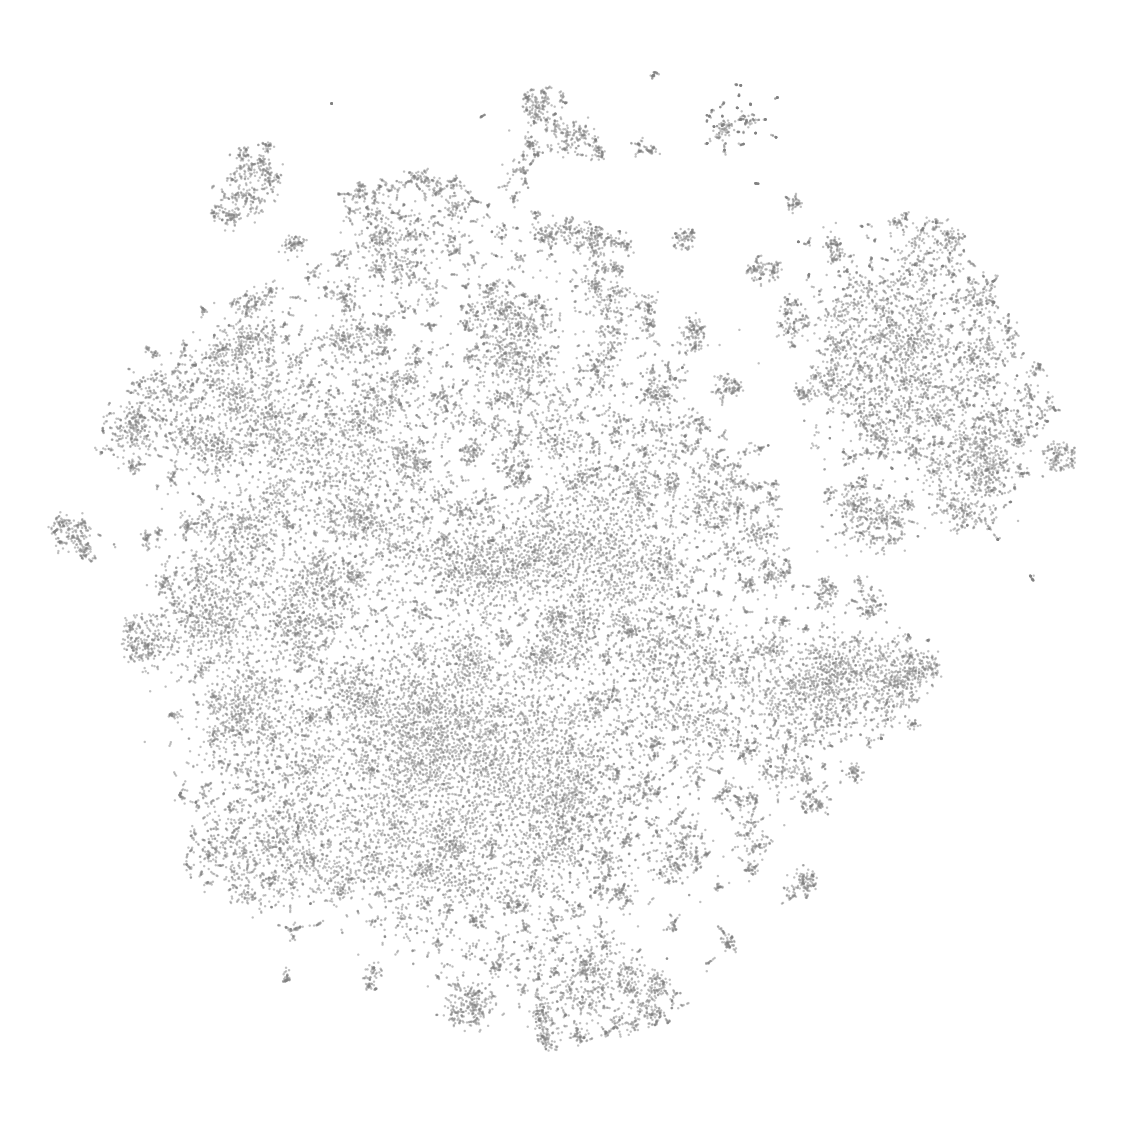

In [76]:
%matplotlib inline

tsne = tsne
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=200, layout="constrained")

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    s=3,  # Increase size
    c="grey",
    marker=".",
    linewidths=None,
    ec="None",
    alpha=0.5,  # Increase opacity
    rasterized=True,
)

ax.axis("equal")
ax.grid()
# ax.xticks([])
# ax.yticks([])
ax.axis("off")

fig.savefig(
    figures_path
    / f"BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_{len(tsne)}.png"
)